In [577]:
import dask.dataframe as dd
import flare_classifier as fc
import torch
import numpy as np
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

from IPython.display import clear_output

In [578]:
class ProgressPlotter:
  def __init__(self) -> None:
    self._history_dict = defaultdict(list)

  def add_scalar(self, tag: str, value)-> None:
    self._history_dict[tag].append(value)

  def display_keys(self,ax,tags):
    if isinstance(tags, str):
      tags = [tags]
    history_len = 0
    ax.grid()
    for key in tags:
      ax.plot(self._history_dict[key], marker="X",label=key)
      history_len = max(history_len,len(self.history_dict[key]))
    if len(tags) > 1:
      ax.legend(loc="lower left")
    else:
      ax.set_ylabel(key)
    ax.set_xlabel('step')
    ax.set_xticks(np.arange(history_len))
    ax.set_xticklabels(np.arange(history_len))
  
  def display(self,groups = None): 
    # groups list ofkeys like [['loss_train','loss_val'],['accuracy']]
    clear_output()
    n_groups = len(groups)
    fig, ax = plt.subplots(n_groups, 1, figsize=(12, 3*n_groups))
    if n_groups == 1:
      ax = [ax]
    for i, keys in enumerate(groups):
      self.display_keys(ax[i],keys) 
    fig.tight_layout()
    plt.show()

  @property
  def history_dict(self):
    return dict(self._history_dict)

In [624]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps")

In [366]:
train_data = pd.read_parquet("train_data.parquet") 
test_data =  pd.read_parquet("test_data.parquet") 
val_data = pd.read_parquet("val_data.parquet") 

In [367]:
feature_names = fc.features_names()

In [368]:
scaler = StandardScaler()

train_data[feature_names] = scaler.fit_transform(train_data[feature_names])
test_data[feature_names] = scaler.transform(test_data[feature_names])
val_data[feature_names] = scaler.transform(val_data[feature_names])

In [370]:
class FlaresDataset(Dataset):
    def __init__(self, df, feature_names):
        self.dataframe = df[feature_names]
        self.labels = df['is_flare']
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        x = self.dataframe.iloc[idx].to_numpy()
        x = torch.tensor(x, dtype=torch.float32)
        
        y = self.labels.iloc[idx]
        y = torch.tensor(y, dtype=torch.float)
        
        return (x, y)

In [559]:
train_dataset = FlaresDataset(train_data, feature_names)
test_dataset = FlaresDataset(test_data, feature_names)
val_dataset = FlaresDataset(val_data, feature_names)

In [634]:
batch_size = 1024

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [635]:
class BaselineNet(nn.Module):
    def __init__(self, n_input):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(n_input, 300),
                            nn.ReLU(),
                            nn.Linear(300, 300),
                            nn.ReLU(),
                            nn.Linear(300, 400), 
                            nn.ReLU(),
                            nn.Linear(400, 1))

    def forward(self, x):
        x = self.layers(x)
        return x

In [656]:
class BinaryClassification(nn.Module):
    def __init__(self, n_input):
        super(BinaryClassification, self).__init__()    
        self.layer_1 = nn.Linear(n_input, 300) 
        self.layer_2 = nn.Linear(300, 300)
        self.layer_3 = nn.Linear(300, 400)
        self.layer_out = nn.Linear(400, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
        self.batchnorm1 = nn.BatchNorm1d(300)
        self.batchnorm2 = nn.BatchNorm1d(300)
        self.batchnorm3 = nn.BatchNorm1d(400)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [663]:
n_input = len(feature_names)

baseline_nn = BinaryClassification(n_input)

In [664]:
learning_rate = 1e-3

model = baseline_nn.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate)

In [665]:
@torch.inference_mode()
def get_correct_count(pred,labels):
  predicted = torch.round(torch.sigmoid(pred))
  return (predicted == labels).sum().item()

In [666]:
@torch.inference_mode()
def calculate_accuracy(model, data_loader, criterion ):
    correct, total = 0, 0 
    loss = 0 
    for batch in data_loader:
        data, labels = batch
        data = data.to(device)
        pred = model(data).squeeze(1).cpu()
        loss += criterion(pred, labels)
        correct += get_correct_count(pred, labels)
        total += labels.size(0)
        
    return correct / total , loss.item() / len(data_loader)

In [667]:
total_step = len(train_dataloader)

def train(model, criterion, optimizer, num_epochs):
    pp = ProgressPlotter()
    for epoch in range(num_epochs):
        correct, total, ep_loss = 0, 0, 0
        
        for i, (data, labels) in enumerate(train_dataloader):  
            
            data = data.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(data).squeeze(1)
            loss = criterion(outputs, labels)
            correct += get_correct_count(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            total += labels.size(0)
            ep_loss += loss.item()
            
            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                
        # Logging
        
        pp.add_scalar('loss_train', ep_loss / len(train_dataloader))
        pp.add_scalar('accuracy_train', correct/total)

        accuracy, loss_val = calculate_accuracy(model, val_dataloader, criterion)
        pp.add_scalar('loss_val', loss_val)
        pp.add_scalar('accuracy_val', accuracy)
        
        pp.display([['loss_train','loss_val'],['accuracy_train','accuracy_val']])
        
    return pp

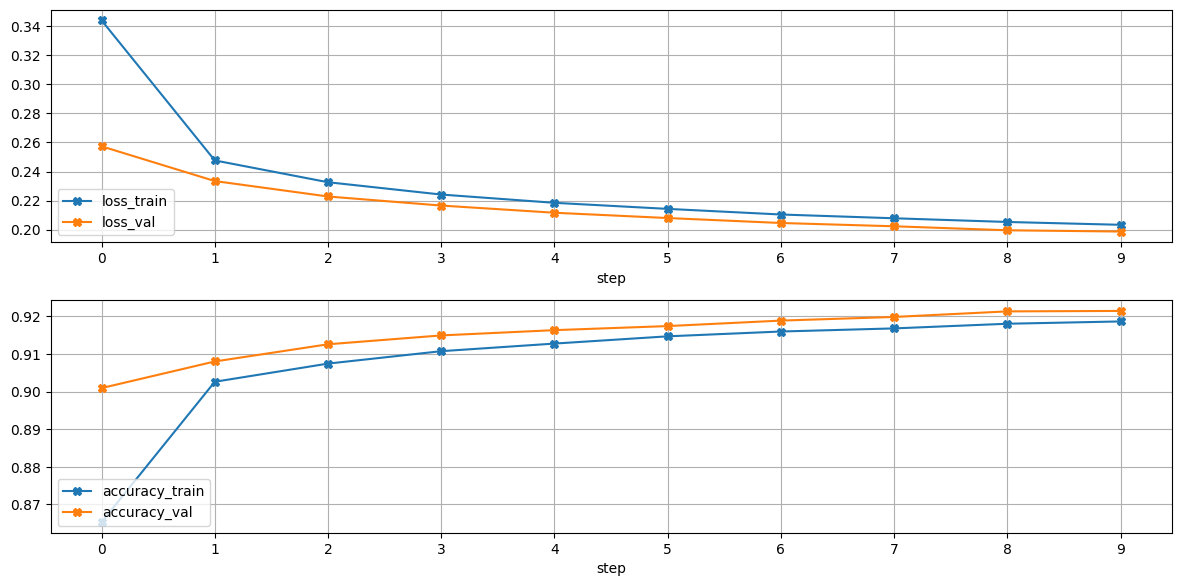

In [668]:
num_epochs = 10

model.train()
pp = train(model, criterion, optimizer, num_epochs=num_epochs)

In [669]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
    
    for batch in test_dataloader:
        data, labels = batch
        
        data = data.to(device)
        y_test_pred = model(data)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(labels.cpu().numpy())

In [670]:
test_predict = np.array([a.squeeze().tolist() for a in y_pred_list][0])
y_test = np.array([a.squeeze().tolist() for a in y_true_list][0])

In [671]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

print(f'recall: {recall_score(y_test, test_predict)}')
print(f'precision: {precision_score(y_test, test_predict)}')
print(f'accuracy: {accuracy_score(y_test, test_predict)}')
print(f'balanced accuracy: {balanced_accuracy_score(y_test, test_predict)}')
print(f'f1_score: {f1_score(y_test, test_predict)}')

recall: 0.9362139917695473
precision: 0.9063745019920318
accuracy: 0.923828125
balanced accuracy: 0.9244266984870042
f1_score: 0.9210526315789473
